## Fairness Metrics

### Table of contents :
1. [Introduction](#1.-Introduction)
2. [Data preparation](#2.-Data-preparation)
3. [Fairness Metrics](#3.-Fairness-Metrics)
	* [Demographic parity](#Demographic-Parity)
    * [Disparate Impact](#Disparate-Impact)
    * [Equal opportunity](#Equal-Opportunity)
    * [Equalised odds](#Equalised-Odds)
4. [Summary](#Summary)
5. [References ](#References)

## 1. Introduction 

Welcome!

We hope you have had a chance to go through Bias Detection and Mitigation in German Credit Dataset. In that tutorial, we also provided an overview of how to compute model fairness with `Demographic Parity` as fairness criteria. 

In this tutorial, we would like to give detailed explanation of different fairness metrics and how to evaluate model fairness on different datasets. 

Following metrics will be explained:
* Demographic parity
* Disparate Impact
* Equal opportunity 
* Equalised odds 

Before detailed explanations, here is sneak peek into the steps involved in the process:

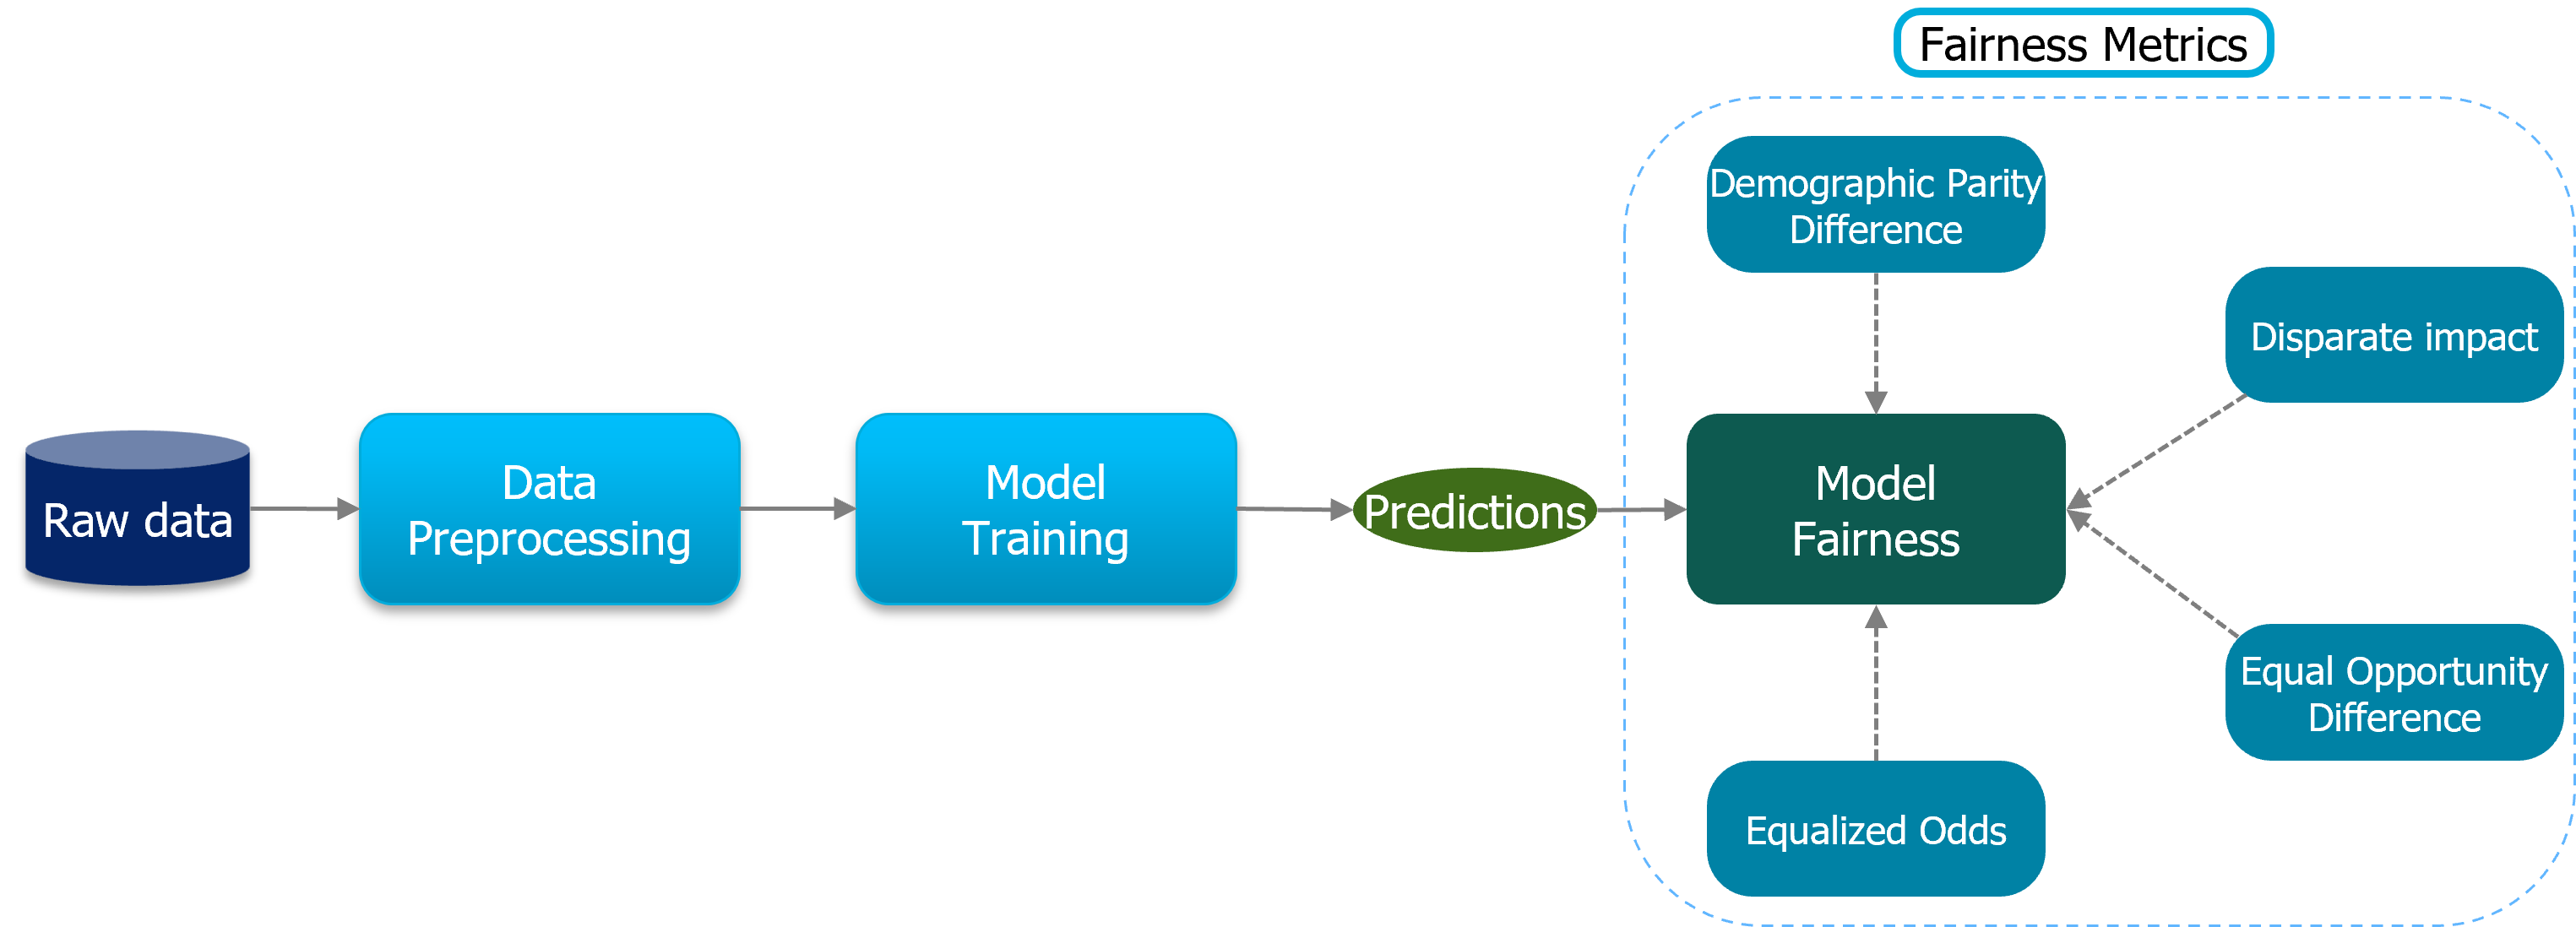

In [1]:
# Preparation
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/fairness_metrics

import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/three_metrics_work_flow_diagram.png')
cv2_imshow(img)

As illustrated in the picture, one must first prepare the data for analysis, then train machine learning model and finally evaluate model fairness with fairness criteria.

In [ ]:
import sys
#sys.path.append('../responsible_ai/three_metrics/')

!pip install opendatasets

from utils import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## 2. Data preparation

In [3]:
dataset_name = "german"  # @param ["german", "adult", "compas", "bank", "gender_discrimination"]

if dataset_name == "german":
    features, target, sensitive_attributes = load_german_data()
elif dataset_name == "adult":
    features, target, sensitive_attributes = load_adult_data()
elif dataset_name == "compas":
    features, target, sensitive_attributes = load_compas_data()
elif dataset_name == "bank":
    features, target, sensitive_attributes = load_bank_data()
else:
    features, target, sensitive_attributes = load_gender_discrimination_data()

features.head()

features : 1000 samples, 44 attributes

targets : 1000 samples

sensitives attributes : 1000 samples, 2 attributes

,month,credit_amount,investment_as_income_percentage,residence_since,number_of_credits,people_liable_for,status_A12,status_A13,status_A14,credit_history_A31,...,property_A124,installment_plans_A142,installment_plans_A143,housing_A152,housing_A153,skill_level_A172,skill_level_A173,skill_level_A174,telephone_A192,foreign_worker_A202
0,6,1169,4,4,2,1,0,0,0,0,...,0,0,1,1,0,0,1,0,1,0
1,48,5951,2,2,1,1,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0
2,12,2096,2,3,1,2,0,0,1,0,...,0,0,1,1,0,1,0,0,0,0
3,42,7882,2,4,1,2,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
4,24,4870,3,4,2,2,0,0,0,0,...,1,0,1,0,1,0,1,0,0,0


In [4]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(features, target,
                                                                     sensitive_attributes,
                                                                     test_size=0.20,
                                                                     stratify=target,
                                                                     random_state=1)
# standardize the data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(X_train)
X_test = scale_orig.fit_transform(X_test)

## 3. Fairness Metrics

### Demographic Parity

#### Definition 
Demographic Parity, also called Independence or Statistical Parity, is one of the most well-known criteria for calculating fairness in machine learning. According to it, proportions of all segments of protected class (eg., gender) should receive equal rates of positive outcome. For example, the probability of getting admission to a college must be independent of gender. In simple terms, outcome must be independent of protected class. 

Prediction of a machine learning model $(\hat{Y})$ must be independent of protected class $A$. i.e,<br>
 $$ P(\hat{Y} = 1 | A=0) = P(\hat{Y} = 1 | A=1) $$

#### Example

Let us work with a small example to illustrate fairness with demographic parity. We will look at a simple classification model  and check model fairness. This model aims to learn the typical income of those who can pay their loan in full and differentiate them from others who tend to default. It is a common way to understand how the model behaves on different groups.


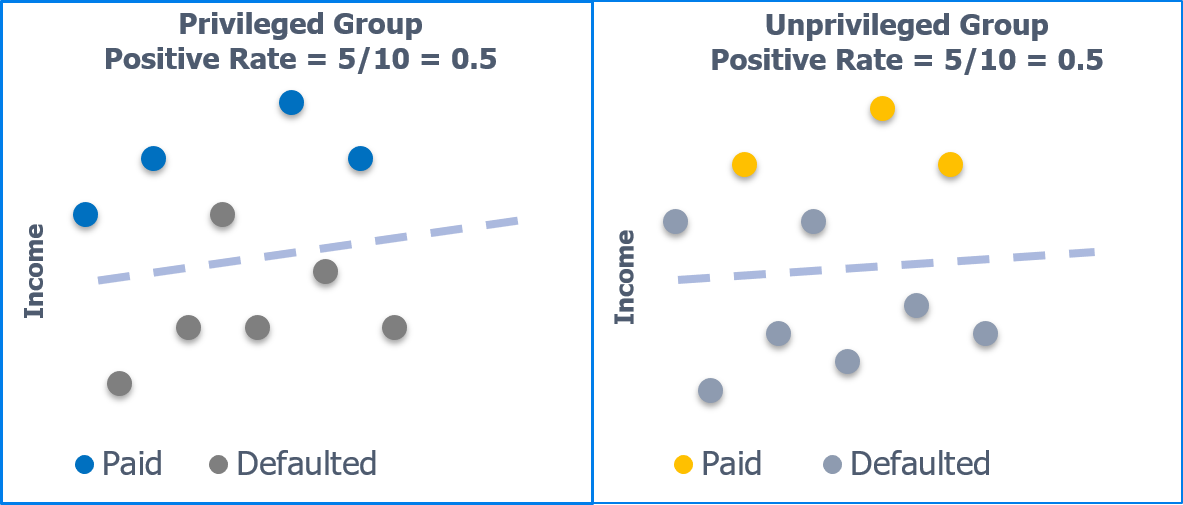

In [5]:
demographic_parity_img = cv2.imread('images/demographic_parity.png')
cv2_imshow(demographic_parity_img)

Assume we have test data of 20 people. We split them into two groups (privileged and unprivileged groups, based on the dataset) and passed them to the model for prediction. Our model simply needs to learn income based threshold on the training data to decide who gets a loan in the future (dotted line in Figure). Above image shows that how our model classifies based on the unprivileged and privileged group. We can observe that the model approval is 50% in each group. This means the model has approved loan for 5 out of 10 applicants (PR = 5/10) for privileged as well as unprivileged group. Well, this is indication of fair treatment meted out by ML model. It treats individuals from the privileged and unprivileged group fairly (positive outcome of the model is independent of the protected class) implying satisfaction of the `Demographic parity` metric.

Positive Rate (PR) is required to be the same for each segment of protected class, $PR_\text{A = unprivileged} = PR_\text{A = privileged}$

#### Demographic Parity Difference
This metric is computed as the difference between the rate of positive outcomes in unprivileged and privileged groups.

In the case Demographic Parity Difference can be calculated as follows:
$$\text{DPD} = P(\hat{Y}=1 \mid A=\text{unprivileged}) - P(\hat{Y}=1 \mid A=\text{privileged})= 0.5 - 0.5 = 0.0$$

A value of 0 indicates demographic parity. In practice, it may not be required for the difference in positive outcome rates to be equal to zero. The aim is to minimise the gap. A value of < 0 implies a higher benefit for the privileged group and a value > 0 implies a higher benefit for the unprivileged group.

### Disparate Impact

#### Definition
The Disparate Impact is a fairness metric that is equivalent to the Demographic Parity metric, It is used to measure the fairness of a system by comparing the proportion of positive outcomes between two groups. This metric is calculated by dividing the propotion of positive outcomes for the unprivileged group by the propotion of positive outcomes for the privileged group.

#### Example
Let's try to understand the Disparate Imapact metric with the example of a classification model (see in the below figure)


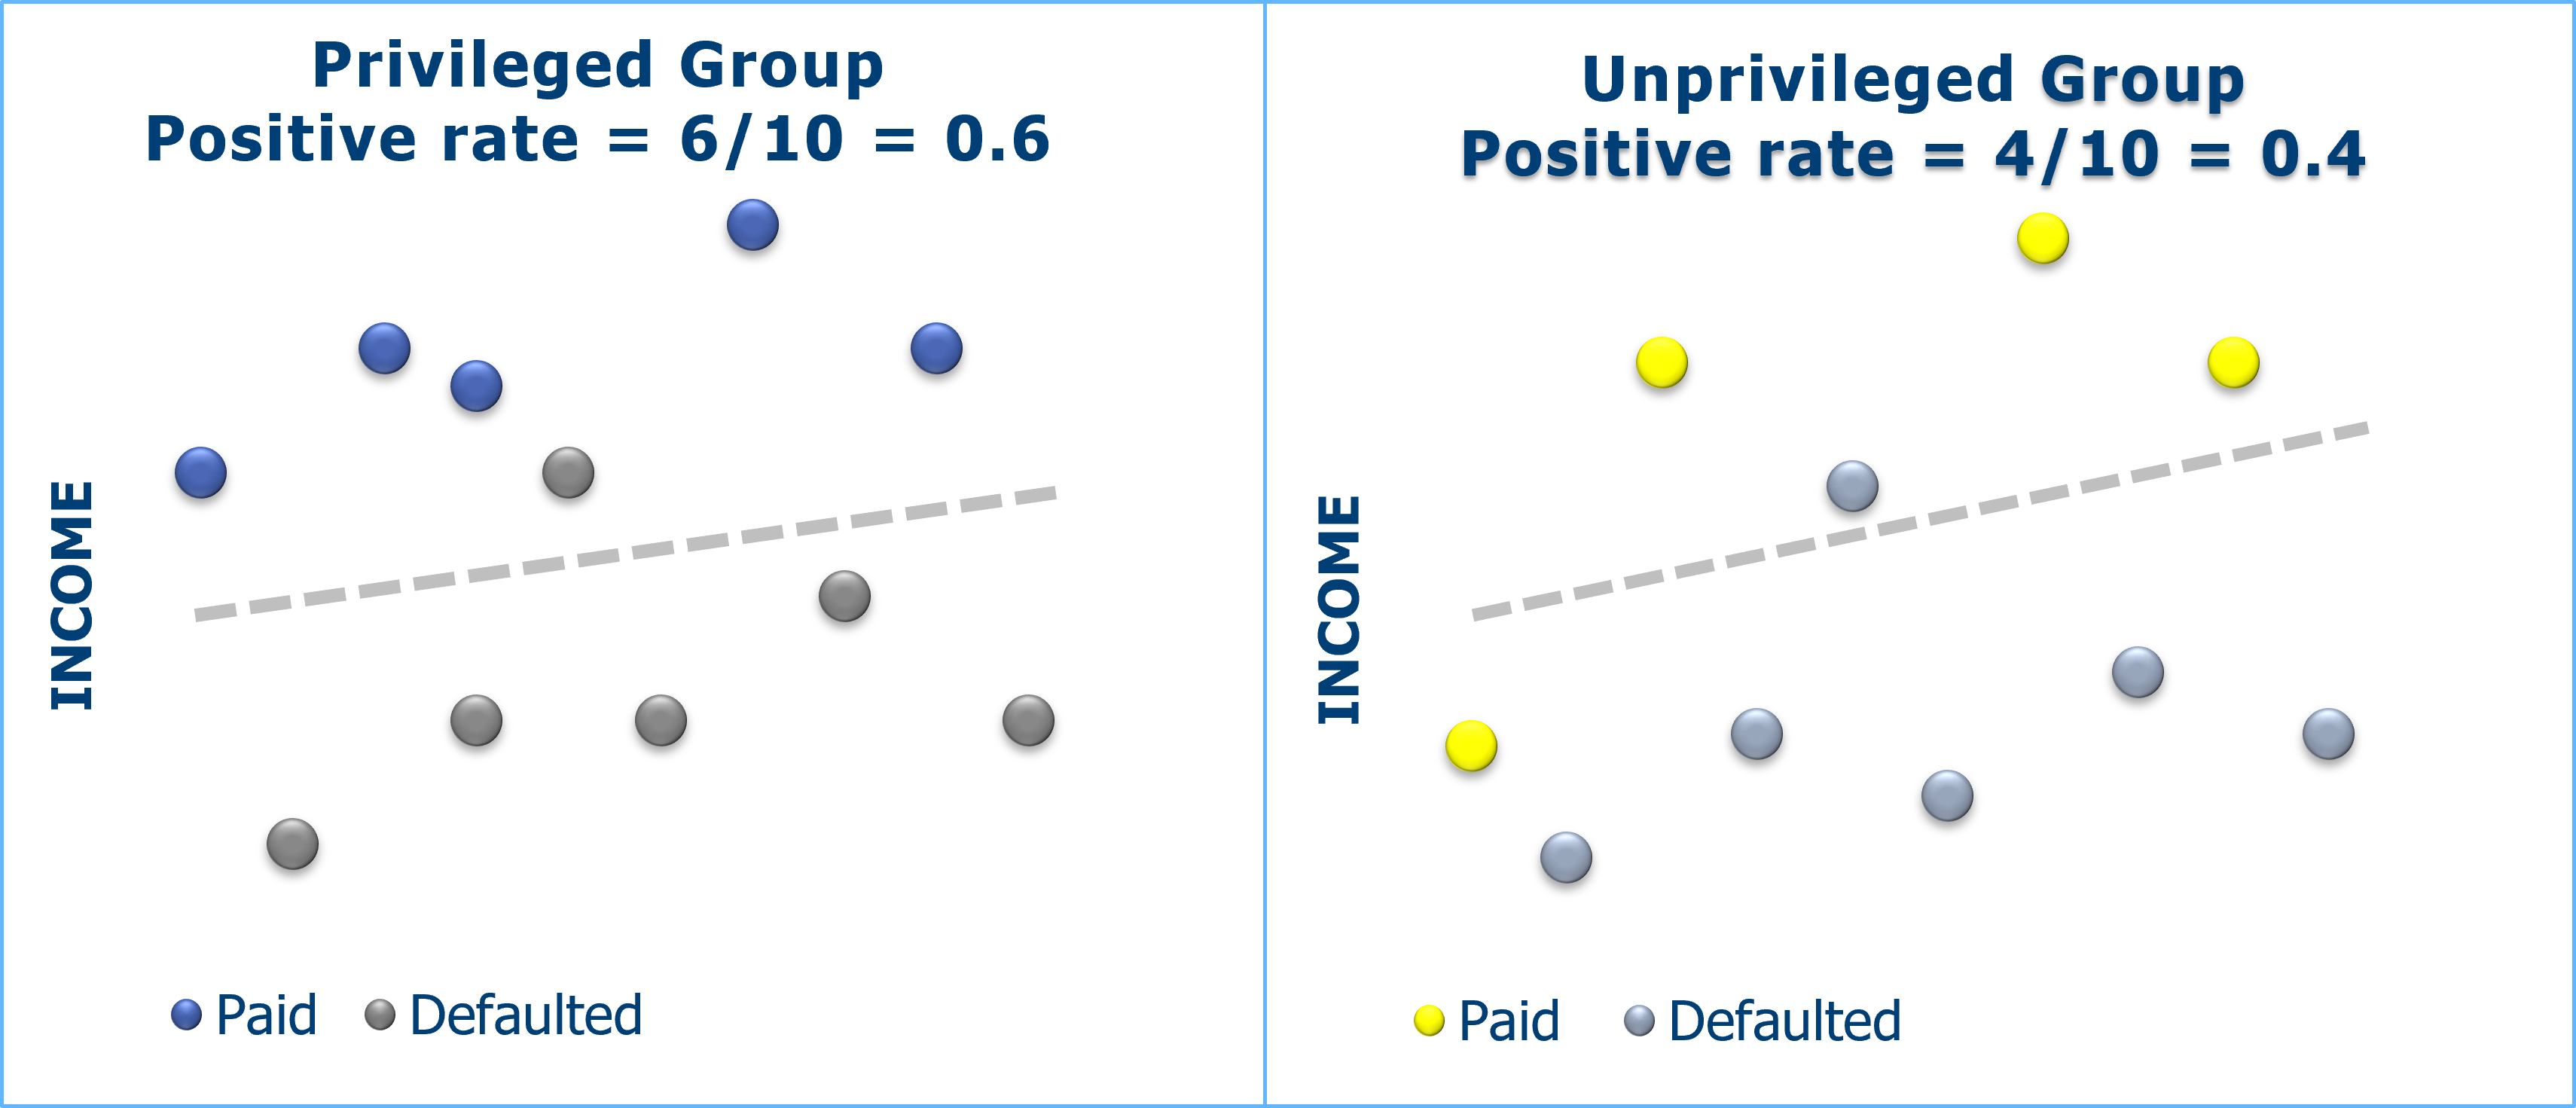

In [6]:
disparate_impact_img = cv2.imread('images/disparate_impact.png')
cv2_imshow(disparate_impact_img)

If you look at the above figure, the classification model gave the positive outcome rate for Privileged Group is 60%, and the positive outcome rate for Unprivileged Group is only 40%. This indicates that the loan approval system is more likely to approve loan applications from Privileged Group than unprivileged Group.

In this case, the Disparate Impact can be calculated as follows:

$$\text{DI} = \frac{P(\hat{Y}=1 \mid A=\text{Unprivileged Group})}{P(\hat{Y}=1 \mid A=\text{Privileged Group})} = \frac{0.4}{0.6} = 0.66$$

If the fairness metric for this ratio falls within the range of 0.8 to 1.25, it indicates that the gap between positive outcome rate for the privileged and unprivileged group is relatively small. This metric is often referred to as the `Four-Fifths` or `80 percent` rule. Ideal value of 1 represents perfect disparate impact. In practice, it may not be required for the ratio in positive outcome rates to be equal to 1. The aim is to minimise the gap. A value of < 1 implies a higher benefit for the privileged group and a value > 1 implies a higher benefit for the unprivileged group

### Equal Opportunity

#### Definition 
Equal opportunity concept states that the model should correctly identify the positive outcome at equal rates across groups (matching the true positive rates for different values of the protected attribute), assuming that people in this group qualify for it.

True positive rate outcome must be independent of the protected class $A$. <br>

$$P(\hat{Y}=1 \mid A=0, Y=1) = P(\hat{Y}=1 \mid A=1,Y=1)$$

#### Example
Let's try to understand the Equal Opportunity metric with the example of a classification model (see in the below figure)



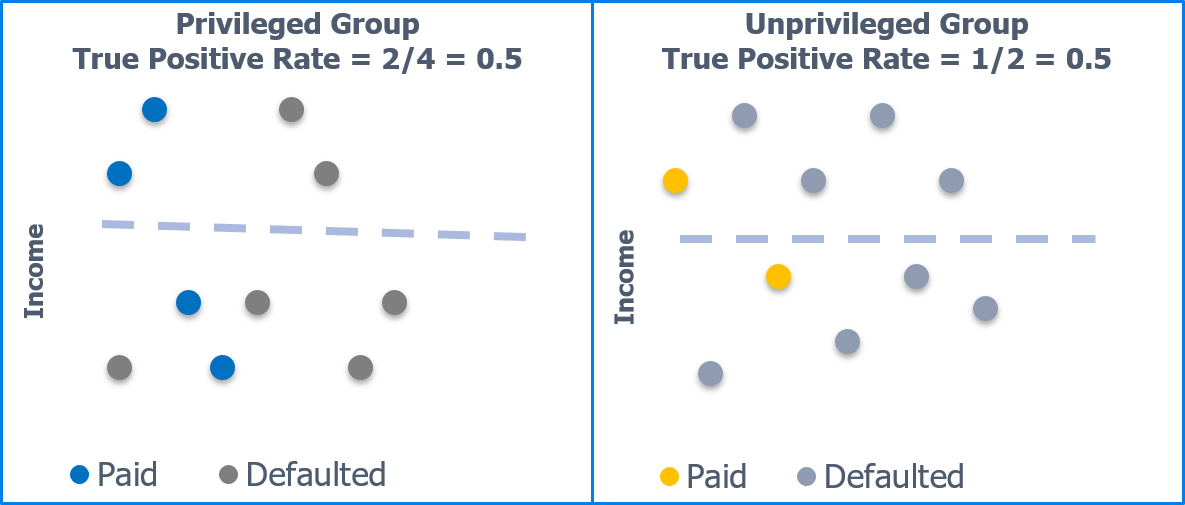

In [7]:
equal_opportunity_img = cv2.imread('images/equal_opportunity.png')
cv2_imshow(equal_opportunity_img)

If you look at the above figure, percentage of positives that are accurately predicted is 50% for both groups. So, for the privileged group, the model correctly approved the loan for 2 applicants out of 4 who were granted a loan (TPR = 2/4). For the unprivileged group, the model correctly approved the loan for 1 applicant out of 2 who were granted a loan (TPR = 1/2). The above model is treating individuals from the privileged and unprivileged group equally and satisfies the `Equal Opportunity` fairness criterion.

True Positive Rate (TPR) is required to be same for each segment of protected class. <br>
$$TPR_\text{A = unprivileged} = TPR_\text{A = privileged}$$

#### Equal Opportunity Difference
This metric is computed as the difference between true positive rate (true positives / positives) between the unprivileged and the privileged groups.<br>
In this case, Equal Opportunity Difference can be calculated as follows:

$$\text{EOD} = TPR_{A=\text{unprivileged}} - TPR_{A=\text{privileged}} = 0.5 - 0.5 = 0$$

A value of 0 indicates Equal Opportunity. In practise, difference between True Positive Rates need not be equal to zero, but we aim to minimise the gap. A value of < 0 implies a higher benefit for the privileged group and a value > 0 implies a higher benefit for the unprivileged group.

### Equalised Odds
#### Definition
Equalized Odds concept states that the model should correctly identify the positive outcome at equal rates across groups (same as in Equal Opportunity), but also miss-classify the positive outcome at equal rates across groups. This means that we are only enforcing equality among individuals who reach similar outcomes. This algorithm is more challenging to implement but achieves one of the highest levels of algorithmic fairness.

Positive outcome of the model must be independent of the protected class $A$. <br>

$$P(\hat{Y}=1 \mid A=0, Y=y) = P(\hat{Y}=1 \mid A=1,Y=y),\ \text{where}\ y \in {0,1}$$

#### Example
Let's understand the equalised odds with the classification model (see the below figure).

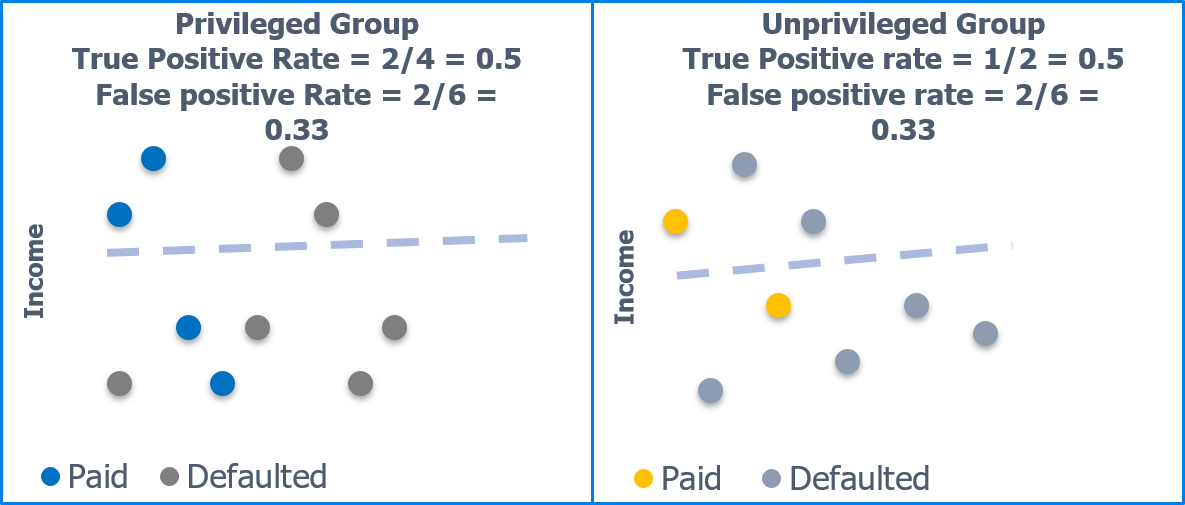

In [8]:
equalised_odds_img = cv2.imread('images/equalised_odds.png')
cv2_imshow(equalised_odds_img)

If you look at the above example, the model correctly identifies positive outcomes at a rate of 50% for both groups. It also has the same proportion of false positives at 33% for both groups. This means, model correctly predicted the positive outcome and also mispredicted the positive outcome equally for both the privileged and unprivileged groups. That is satisfaction of `Equality of Odds` criterion.

True Positive Rate (TPR) and False Positive Rate (FPR) are required to be the same for each segment of the protected class.<br>
$1. FPR_\text{A = unprivileged} = FPR_\text{A = privileged}$,<br> $ 2. TPR_\text{A = unprivileged} = TPR_\text{A = privileged}$

#### Equalized Odds
This metric is computed as average of absolute difference between false positive rate and true positive rate for unprivileged and privileged groups. <br>

In this case, Absolute Average Odd Difference can be calculated as follows:

$$\text{AAOD} = \frac{\left[ |FPR_{A=\text{unprivileged}} - FPR_{A=\text{privileged}}| + |TPR_{A=\text{unprivileged}} - TPR_{A=\text{privileged}}| \right]}{2} = \frac{(0.33 - 0.33) + (0.5 - 0.5)}{2} = 0 $$

A value of 0 indicates equality of odds.

Please look at the code below to get mathematical idea of all the above three metrics.

In [9]:
# Function to evaluate the fairness of the model
log_dict = {}


def get_fairness(X, y, model, privileged_group, preds):
    y_unprivileged, preds_unprivileged, X_unprivileged = y[privileged_group == False], preds[
        privileged_group == False], X[privileged_group == False]
    y_privileged, preds_privileged, X_privileged = y[privileged_group], preds[privileged_group], X[
        privileged_group]
    total_approvals = preds.sum()
    unprivileged_approvals = preds_unprivileged.sum()
    privileged_approvals = preds_privileged.sum()

    cm_unprivileged, disp_unprivileged = plot_confusion_matrix(y_unprivileged, preds_unprivileged)
    disp_unprivileged.ax_.set_title("Unprivileged Group")
    cm_privileged, disp_privileged = plot_confusion_matrix(y_privileged, preds_privileged)
    disp_privileged.ax_.set_title("Privileged Group")

    unprivileged_PR = (cm_unprivileged[1, 1] + cm_unprivileged[0, 1]) / cm_unprivileged.sum()
    privileged_PR = (cm_privileged[1, 1] + cm_privileged[0, 1]) / cm_privileged.sum()
    print("Positive rate of unprivileged group: {}".format(round(unprivileged_PR, 3)))
    print("Positive rate of privileged group: {}".format(round(privileged_PR, 3)))
    DPD = unprivileged_PR - privileged_PR
    print("Demogrpahic Parity Difference :", DPD)
    DI = unprivileged_PR/privileged_PR
    print(f"Disparate Impact: {DI}")
    unprivileged_TPR = cm_unprivileged[1, 1] / cm_unprivileged[1].sum()
    privileged_TPR = cm_privileged[1, 1] / cm_privileged[1].sum()
    print("True positive rate of unprivileged group: {}".format(round(unprivileged_TPR, 3)))
    print("True positive rate of privileged group: {}".format(round(privileged_TPR, 3)))
    equal_opportunity_difference = unprivileged_TPR - privileged_TPR
    print("Equal Opportunity Difference :", equal_opportunity_difference)

    unprivileged_FPR = cm_unprivileged[0, 1] / cm_unprivileged[0].sum()
    privileged_FPR = cm_privileged[0, 1] / cm_privileged[0].sum()
    print("False positive rate of unprivileged group: {}".format(round(unprivileged_FPR, 3)))
    print("False positive rate of privileged group: {}".format(round(privileged_FPR, 3)))
    average_abs_odds_difference = 0.5 * (
            abs(unprivileged_FPR - privileged_FPR) + abs(unprivileged_TPR - privileged_TPR))
    print("Average Abs Odd  Difference ", average_abs_odds_difference)

    # log the statistics of the model
    log_dict['total_approvals'] = total_approvals
    log_dict['unprivileged_approvals'] = unprivileged_approvals
    log_dict['privileged_approvals'] = privileged_approvals
    log_dict['unprivileged_PR'] = round(unprivileged_PR, 3)
    log_dict['privileged_PR'] = round(privileged_PR, 3)
    log_dict['unprivileged_TPR'] = round(unprivileged_TPR, 3)
    log_dict['privileged_TPR'] = round(privileged_TPR, 3)
    log_dict['unprivileged_FPR'] = round(unprivileged_FPR, 3)
    log_dict['privileged_FPR'] = round(privileged_FPR, 3)
    # log fairness of the model
    log_dict["DPD"] = round(DPD, 3)
    log_dict["DI"] = round(DI, 3)
    log_dict["EOD"] = round(equal_opportunity_difference, 3)
    log_dict["AAOD"] = round(average_abs_odds_difference, 3)

    return log_dict

### Model Fairness

In [10]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
preds_baseline = model.predict(X_test)

Get model fairness with respect to sensitive attribute.

Positive rate of unprivileged group: 0.592
Positive rate of privileged group: 0.801
Demogrpahic Parity Difference : -0.20948776861738072
Disparate Impact: 0.7385731151964918
True positive rate of unprivileged group: 0.607
True positive rate of privileged group: 0.911
Equal Opportunity Difference : -0.3035714285714286
False positive rate of unprivileged group: 0.571
False positive rate of privileged group: 0.487
Average Abs Odd  Difference  0.19391025641025642


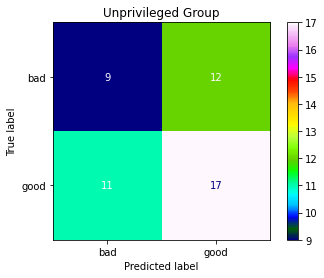

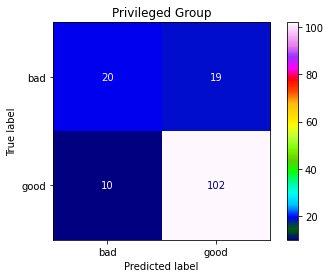

In [11]:
# Evaluate the model
sensitive_attribute = 'age'
log_dict = get_fairness(X_test, y_test, model, Z_test[sensitive_attribute] == 1, preds_baseline)

Confusion matrices above show how the model performs on some test data. We also print additional information (calculated from confusion matrices) to assess the model fairness. For instance,
* The model predicted and gave favourable outcomes to 150 people. Among these individuals, 121 belonged to the privileged group and 29 belonged to the unprivileged group.
* Positive rate (PR) for privileged group is 0.801, and the PR for unprivileged group is 0.592 . PR = TP /(TP+FP+TN+FN).
* True positive rate (TPR) for the privileged group is 0.911, and TPR for the  unprivileged group is 0.607 . For the privileged group, the TPR = TP /(TP+FN).
* False positive rate (FPR) for the privileged group is 0.487, and the FPR for the unprivileged group is 0.571 .For the privileged group, TPR = FP /(FP+TN).

Let's check model fairness. In this tutorial, we explore three different types of metrics.


##### Demographic parity: 
* As discussed in the Demographic parity section, model is fair if all segments of the protected class receive equal proportion/rate of positive outcomes. We refer to this proportion as `Positive Rate` of the model.

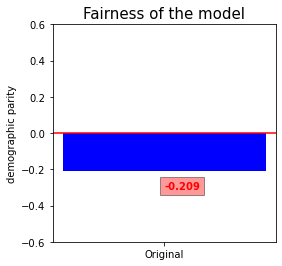

* As seen in the above diagram, difference between positive rates of unprivileged and privileged group is -0.209 , which means the privileged group gets 20.9% more positive outcome.
* Demographic parity difference (DPD) must be close to zero for the classifier to be fair.
* Model fairness is -0.209 , which means the model is not satisfied demographic parity fairness criterion . To improve model fairness, we need to mitigate(minimize) the bias.

##### Demographic parity: 
* As discussed in the Demographic parity section, model is fair if all segments of the protected class receive equal proportion/rate of positive outcomes. We refer to this proportion as `Positive Rate` of the model.

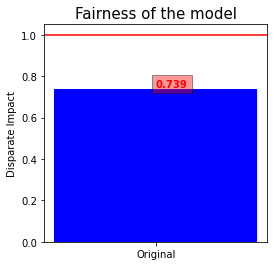

* As seen in the above diagram , the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group is 0.739
* Disparate Impact (DI) must be close to One for the classifier to be fair.
* Model fairness is 0.739, which means the model is not satisfied Disparate Impact fairness criterion . To improve model fairness , we need to mitigate (minimize) the bias.

##### Equal opportunity : 
* As discussed in the Equal opportunity section, model is fair, if the proportion of people who should be selected by the model (`positives`) that are correctly selected by the model is the same for each group. We refer to this proportion as the true positive rate (TPR) of the model.


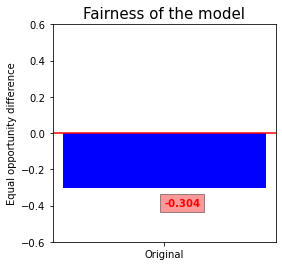

* As seen in the above diagram the difference between positive rates of the unprivileged and privileged group is -0.304, which means the privileged group gets 30.4% more true positive rate. In other words, for privileged group,almost all people who should be approved are actually approved. For unprivileged group, if you should be approved, your chances of actually being approved are much lower.
* Equal opportunity difference (EOD) must be close to zero for the classifier to be fair.
* Model fairness is -0.304. which means the model is not satisfied Equal opportunity fairness criterion . To improve model fairness , we need to mitigate (minimize) the bias.

##### Equalized odds : 
* As discussed in the equalized section , model is fair, if the proportion of people correctly identify the positive outcome at equal rates across groups , but also miss-classify the positive outcome at equal rates across groups . we refer to this TPR and FPR of the model.


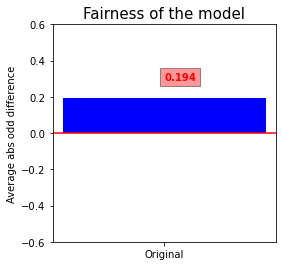

* As seen in the above diagram , the average abs odd difference between privileged group and unprivileged group is 0.194
* Average abs odds difference (AAOD) must be close to zero for the classifier to be fair.
* Model fairness is 0.194, which means the model is not satisfied Equalized odd fairness criterion . To improve model fairness , we need to mitigate (minimize) the bias.

In [12]:
# Display and analyze the logs
display_log(log_dict)

## Summary 

In this tutorial we explored most common definitions of ‘Mathematical Fairness’ and how to check ML model fairness. In practice, we need to mitigate bias to make ML systems fair. So, one must take a closer look at every step in the machine learning workflow, from data collection to deployment of model onto the device. 

We have intentionally avoided explaining how to minimize bias to ensure model fairness here. Also note that it is not possible to optimize a model for more than one type of fairness in real time. Read more about this here: [Impossibility Theorem of Machine Fairness](#https://arxiv.org/abs/2007.06024). 

Which fairness criterion should be selected for a given problem if you can only satisfy one? 
As with most ethical questions, the correct answer is usually not straightforward, and picking fairness criteria should depend on the specifications of the project. This tutorial is an attempt to keep enthusiasts informed about possible fairness metrics.

## References 
1. Hardt, M., Price, E., and Srebro, N. (2016). [“Equality of opportunity in supervised learning,”](#https://arxiv.org/pdf/1906.09688.pdf) in Advances in Neural Information Processing Systems, eds D. D. Lee, M. Sugiyama, U. V. Luxburg, I. Guyon, and R. Garnett (Barcelona: Curran Associates, Inc.), 3315–3323.
2. Chouldechova, A. (2017). [Fair prediction with disparate impact: a study of bias in recidivism prediction instruments](#https://arxiv.org/abs/1610.07524). 
3. Zafar, M. B., Valera, I., Gomez Rodriguez, M., and Gummadi, K. P. (2017a). [Fairness Beyond Disparate Treatment & Disparate Impact: Learning Classification without Disparate Mistreatment](#https://arxiv.org/abs/1610.08452).
4. [The Impossibility Theorem of Machine Fairness -- A Causal Perspective](#https://arxiv.org/abs/2007.06024).